# DCGAN

## dataset
- [x] mnist
- [ ] fashion mnist
- [ ] celebA

## model architecture for stable DC GANs
- [x] Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- [x] Use Batch-norm for generator and discriminator.
- [x] Remove fully connected layers.
- [x] Use Relu activation in generator for all layers except for the output, which uses Tanh.
- [x] Use leakyRelu activation in the discriminator for all layers.
  - [x] alpha = 0.2






# installation

In [3]:
!pip install tensorflow-gpu==2.0.0-rc1
# !conda install -y -q seaborna


# Imports

In [4]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import seaborn as sns
print(sns.__version__)
import numpy as np
print(np.__version__)
keras = tf.keras

K = keras.backend


2.0.0-rc1
0.9.0
1.16.5


# Configurations

In [0]:
batch_size = 128
epochs = 50
noise_dim = 100

# datasets

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


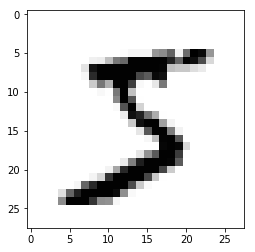

(60000, 28, 28, 1)
<PrefetchDataset shapes: (None, 28, 28, 1), types: tf.float32>


In [6]:
dataset = keras.datasets.mnist.load_data()

X_train, X_test = dataset[0][0], dataset[1][0]
Y_train, Y_test = dataset[0][1], dataset[1][1]

del(dataset)

print(X_train.shape)
print(X_test.shape)

print(Y_train.shape)
print(Y_test.shape)

plt.imshow(X_train[0], cmap="Greys")
plt.show()

X_train = X_train.reshape([*X_train.shape] + [1]).astype('float32')
X_test = X_test.reshape([*X_test.shape] + [1]).astype('float32')
print(X_train.shape)

X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5) / 127.5

data = tf.data.Dataset.from_tensor_slices(X_train)

data = data.shuffle(batch_size * 10).batch(batch_size).prefetch(batch_size * 5)
print(data)

# DECONVOLUTION MODEL (GENERATOR)

- INPUT : a random noise with dimension of (100,)
- OUTPUT : generated image with dimension of (28, 28, 1)


In [0]:
initializer = keras.initializers.RandomNormal(stddev=0.02)

In [0]:
def build_generator():
    
    model = keras.models.Sequential()
    
    model.add(keras.layers.Dense(units=7*7*256, 
                                 activation=None, 
                                 kernel_initializer=initializer,
                                 input_shape=(100,),
                                 use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Reshape(target_shape=[7, 7, 256]))
    
    model.add(keras.layers.Conv2DTranspose(filters=128, kernel_size=(5, 5),
                                          strides=(1, 1), padding='same', activation=None,
                                           kernel_initializer=initializer,
                                           use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Conv2DTranspose(filters=64, kernel_size=(5, 5),
                                          strides=(2, 2), padding='same', activation=None,
                                           kernel_initializer=initializer,
                                           use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Conv2DTranspose(filters=1, kernel_size=(5, 5),
                                          strides=(2, 2), padding='same', activation=None,
                                           kernel_initializer=initializer,
                                           use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('tanh'))
    
    return model

# DISCRIMINATOR MODEL

- INPUT : a image with 28x28x1 size.
- OUTPUT : the probability whether the image is fake or real

In [0]:
def build_discriminator():
    
    model = keras.models.Sequential()
    
    model.add(keras.layers.Conv2D(filters=64,
                                  kernel_size=(5, 5),
                                  input_shape=(28, 28, 1), 
                                  strides=(2, 2),
                                  padding='same',
                                  activation=None,
                                  kernel_initializer=initializer,
                                  use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Conv2D(filters=128,
                                  kernel_size=(5, 5),
                                  strides=(2, 2),
                                  padding='same',
                                  activation=None,
                                  kernel_initializer=initializer,
                                  use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(alpha=0.2))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=1, 
                                 activation=None, 
                                 kernel_initializer=initializer,
                                 use_bias=False))
    
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('sigmoid'))
    return model

# Losses



$$\min_{\theta_d}\max_{\theta_g} E_{x\sim p_{data}}\log D(x) + E_{z\sim p_{z}}\log(1 - D(G(z)))$$

$$p_z \sim 표준정규분포$$ 

In [0]:
def generator_loss(y_pred):
    y_true = keras.backend.ones_like(y_pred)
    cross_entropy = keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.math.reduce_mean(cross_entropy)

In [0]:
def discriminator_loss(y_pred, x):
    if x:
        y_true = keras.backend.ones_like(y_pred)
    else:
        y_true = keras.backend.zeros_like(y_pred)
    
    cross_entropy = keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.math.reduce_mean(cross_entropy)

# Training


In [35]:
generator = build_generator()
generator.summary()
discriminator = build_discriminator()
discriminator.summary()

opt_g = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
opt_d = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_14 (Batc (None, 12544)             50176     
_________________________________________________________________
re_lu_6 (ReLU)               (None, 12544)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_15 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
re_lu_7 (ReLU)               (None, 7, 7, 128)        

In [0]:
def print_tensors(tensors):
    for each in tensors:
        print(f'{each.name} {each.shape}')

In [0]:
losses = {
    'generator': [],
    'discriminator': []
}

In [0]:
# @tf.function
def train_step(real_data):
    z = np.random.randn(batch_size, noise_dim)
    
    with tf.GradientTape() as tape_g, tf.GradientTape() as tape_d:
        Gz = generator(inputs=z, training=True)
        Dz = discriminator(inputs=Gz, training=True)
        Dx = discriminator(inputs=real_data, training=True)
        
        loss_g = generator_loss(Dz)
        loss_d = discriminator_loss(Dz, x=False)
        loss_d += discriminator_loss(Dx, x=True)
        
        losses['generator'].append(loss_g)
        losses['discriminator'].append(loss_d)
        
    grads_g = tape_g.gradient(loss_g, generator.trainable_variables)
    grads_d = tape_d.gradient(loss_d, discriminator.trainable_variables)

    opt_g.apply_gradients(zip(grads_g, generator.trainable_variables))
    opt_d.apply_gradients(zip(grads_d, discriminator.trainable_variables))
    
    return Gz
    
    
    
    
    

In [0]:
def imshow(tensor, e):
    
    fig = plt.figure(figsize=(16, 24))
    for i in range(tensor.numpy().shape[0]):
      plt.subplot(16, 8, i+1)
      img = tf.reshape(tensor[i], shape=[28, 28])
      plt.imshow(img.numpy() * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    if e:
      plt.savefig(fname=f'{e}.png')
    plt.show()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

-------------------- 0 --------------------


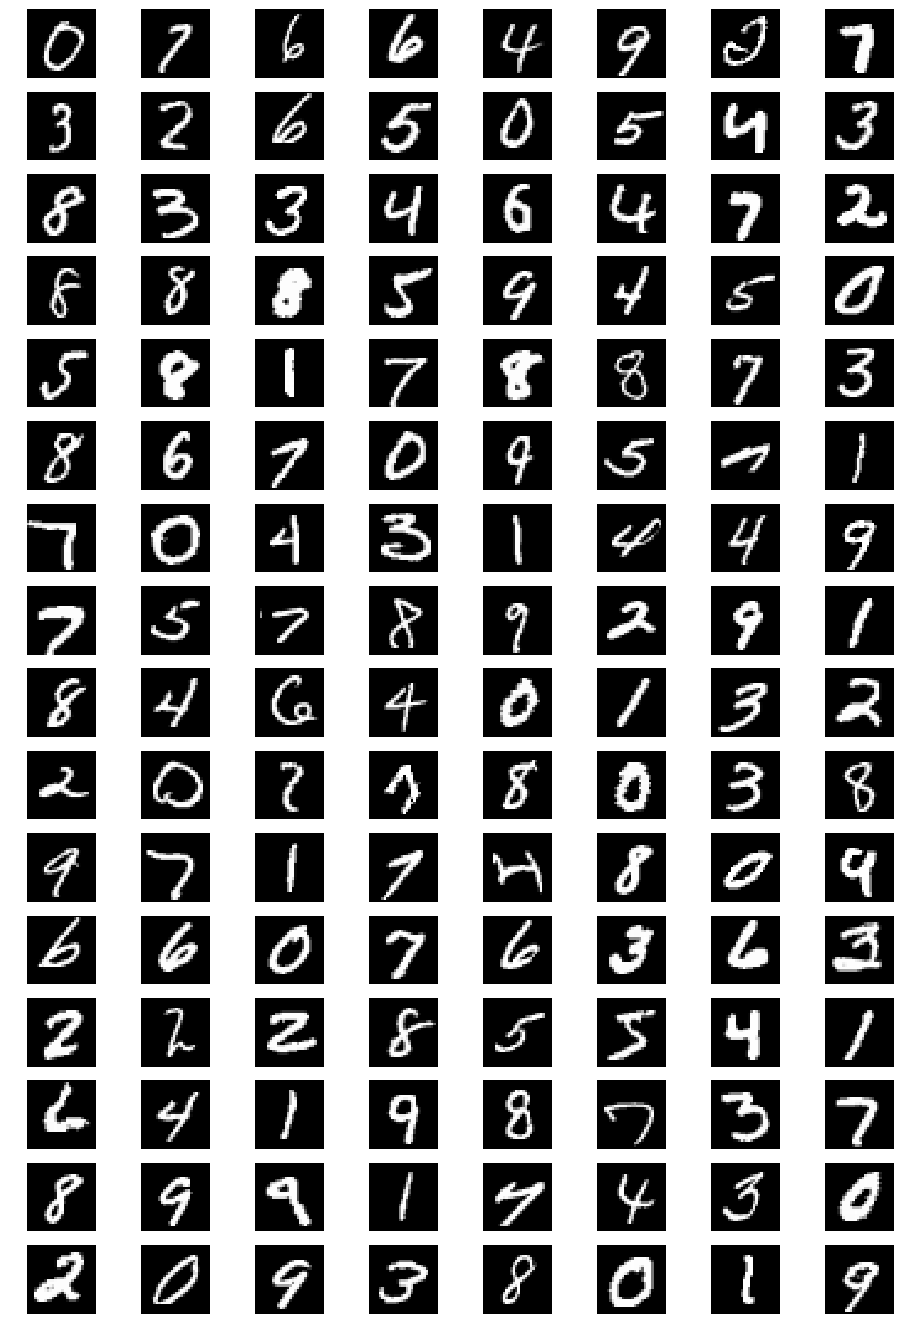

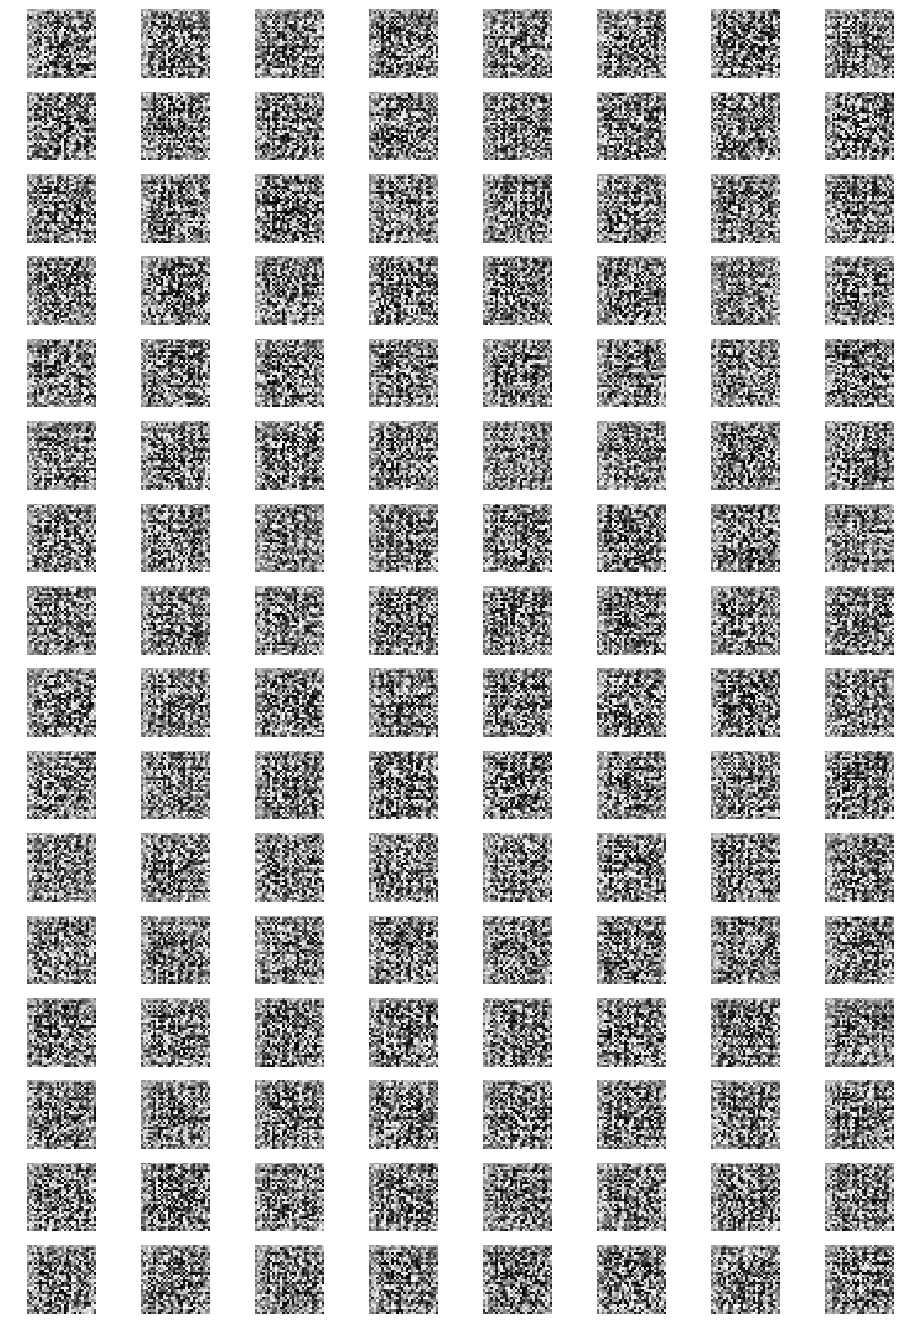

KeyboardInterrupt: ignored

In [40]:
for e in range(epochs):

    
    for idx, real_data in enumerate(data):
        gz = train_step(real_data)
        if idx == 0:
          print(f'-------------------- {e} --------------------')
          imshow(real_data, None)
          imshow(gz, e)

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
